# 패키지 로딩

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 하이퍼 파라미터 설정

In [3]:
PAST = 12
SPLIT = 0.8
NEURON = 500
RNN_SHAPE = (PAST, 1)
EPOCH = 100
BATCH = 64

# 데이터 로딩 및 스케일링

In [5]:
df = pd.read_csv('airline.csv', header=None)
print(df.shape)
display(df.head())

(144, 2)


,0,1
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
df = df[1]
display(df.head())

0    112
1    118
2    132
3    129
4    121
Name: 1, dtype: int64

In [9]:
raw_DB = np.array(df).astype(float)
print(raw_DB.flatten()) # flatten : 1차원 벡터로 만듦
scaler = MinMaxScaler() # 정규화
raw_DB = scaler.fit_transform(raw_DB.reshape(-1,1))
print(raw_DB.flatten())

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]
[0.01544402 0.02702703 0.05405405 0.04826255 0.03281853 0.05984556
 0.08494208 0.08494208 0.06177606 0.02895753 0.         0.02702703
 0.02123552 0.04247104 0.07142857 0.05984556 0.04054054 0.08687259
 0.12741313 0.12741313 0.1042471  0.05598456 0.01930502 0.06949807


# Time Step 데이터 생성 및 학습/평가 데이터 분할

In [12]:
data = []
for i in range(len(raw_DB)-PAST):
    data.append(raw_DB[i:i+PAST+1]) # 1st: 0~12, 2nd: 1~13, 3rd : 2~14, 오른쪽으로 한칸씩 이동하면서 13개의 데이터를 끊어 옴

reshaped_data = np.array(data)

In [15]:
print(reshaped_data.shape) # 전체 time step 데이터 : 132개(13행 1열짜리 데이터)
np.random.shuffle(reshaped_data)
print(reshaped_data[0])

(132, 13, 1)
[[0.45945946]
 [0.58301158]
 [0.56370656]
 [0.61003861]
 [0.71042471]
 [0.85714286]
 [0.87837838]
 [0.69305019]
 [0.58494208]
 [0.4980695 ]
 [0.58108108]
 [0.6042471 ]
 [0.55405405]]


- 입력 값과 출력 값으로 분리
>- 인덱스 0~11 (12 months)를 입력 값으로 사용
>- 12번째 인덱스를 출력 값으로 사용

In [18]:
x_data = reshaped_data[:, :PAST]
y_data = reshaped_data[:, -1]

split_boundary = int(reshaped_data.shape[0] * SPLIT)
x_train = x_data[:split_boundary]
x_test = x_data[split_boundary:]
y_train = y_data[:split_boundary]
y_test = y_data[split_boundary:]

In [19]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (105, 12, 1)
x_test shape: (27, 12, 1)
y_train shape: (105, 1)
y_test shape: (27, 1)


# 모델 생성

In [ ]:
- LSTM(unit, input_shape=(time_step, feature))
>- unit : hidden state의 크기, 임의의 개수를 설정
>- time_step : 과거 몇 개의 데이터를 학습할 것인지를 설정
>- feature : 입력값 x의 차원 (여행객 수만 고려하기 때문에 특성 차원 수는 1)

In [24]:
model = Sequential()
model.add(LSTM(units=NEURON, input_shape=RNN_SHAPE))
model.add(Dense(units=NEURON, activation='relu'))
model.add(Dense(units=1, activation='linear')) # 분류가 아니라 실수를 예측해야 돼서 linear
model.summary()

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 500)                 │       1,004,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,255,001 (4.79 MB)

 Trainable params: 1,255,001 (4.79 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH, verbose =1)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.1634 - mae: 0.3432
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0259 - mae: 0.1258
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0314 - mae: 0.1437
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0122 - mae: 0.0747
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0183 - mae: 0.0993
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0085 - mae: 0.0702
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0125 - mae: 0.0920
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0120 - mae: 0.0879
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0074 - mae: 0.0646
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0102 - mae: 0.0702
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0084 - mae: 0.0652
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0065 - mae: 0.0612
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


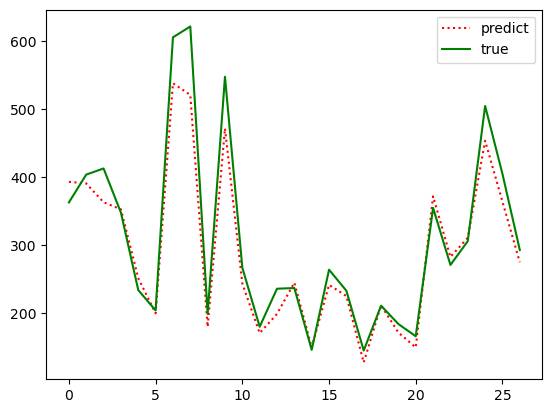

In [26]:
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred) # 정규화한 값을 원래 값으로 바꿈 
y_test = scaler.inverse_transform(y_test)

plt.plot(pred, 'r:', label='predict')
plt.plot(y_test, 'g-', label='true')
plt.legend()
plt.show()